In [31]:
import os
import shutil
import sys
import numpy as np
import scipy
import matplotlib.pyplot as plt
import h5py
import tensorflow as tf
from tensorflow.python.framework import ops
import cv2

In [2]:
data_path = os.getcwd() + "\\data\\"

In [80]:
def read(data_path, folder_type='train'):
    if folder_type.lower() == 'train':
        path = data_path + "\\" + "Training"
    elif folder_type.lower() == 'test':
        path = data_path + "\\" + "Test"
    else:
        print("Wrong folder path")
        sys.exit(1)
    
    total_fruits_list  = os.listdir(path)
    total_fruits_count = len(total_fruits_list)
    
    
    
    all_images_count = 0
    
    total_fruits_list_temp = total_fruits_list[:5]
    total_fruits_count_temp = len(total_fruits_list_temp)
    
    for fruit in total_fruits_list_temp:        
        for img in os.listdir(path + "\\" + fruit):
            all_images_count += 1
            
    
    data = {}
    labels = {}
    data[folder_type] = np.zeros(shape=(all_images_count, 100, 100, 3), dtype=np.float32)
    labels[folder_type] = np.zeros(all_images_count, dtype=np.int32)
    print(data[folder_type].shape)
    print(labels[folder_type].shape)
    
    data_counter = 0
    label_counter = 0
    
    label_to_idx_dict = {}
    idx_to_label_dict = {}
    
    for fruit in total_fruits_list_temp:        
        print(folder_type, " : ", fruit)  
        label_to_idx_dict[fruit] = label_counter
        idx_to_label_dict[label_counter] = fruit
        for img in os.listdir(path + "\\" + fruit):
            cur_img = cv2.imread(path + "\\" + fruit + "\\" + img)            
            data[folder_type][data_counter,:,:,:] = cur_img                        
            labels[folder_type][data_counter] = label_counter
            data_counter += 1
        label_counter += 1
            
    return data[folder_type], labels[folder_type], len(total_fruits_list_temp), label_to_idx_dict, idx_to_label_dict
    

In [81]:
training_data, training_labels, num_classes, \
    label_to_idx_dict_train,idx_to_label_dict_train = read(data_path, folder_type="train")

test_data, test_labels, num_classes, \
    label_to_idx_dict_test, idx_to_label_dict_test = read(data_path, folder_type="test")

(2449, 100, 100, 3)
(2449,)
train  :  Apple Braeburn
train  :  Apple Golden 1
train  :  Apple Golden 2
train  :  Apple Golden 3
train  :  Apple Granny Smith
(817, 100, 100, 3)
(817,)
test  :  Apple Braeburn
test  :  Apple Golden 1
test  :  Apple Golden 2
test  :  Apple Golden 3
test  :  Apple Granny Smith


In [43]:
'''
hf_train_data = h5py.File('training_data.h5', 'w')
hf_train_labels = h5py.File('training_labels.h5', 'w')
hf_test_data = h5py.File('test_data.h5', 'w')
hf_test_labels = h5py.File('test_labels.h5', 'w')

hf_train_data.create_dataset('training_data', data=training_data)
asciiList = [n.encode("ascii", "ignore") for n in training_labels]
hf_train_labels.create_dataset('training_labels', (len(asciiList),1),'S25', asciiList)

hf_test_data.create_dataset('test_data', data=test_data)
asciiList_test = [n.encode("ascii", "ignore") for n in test_labels]
hf_test_labels.create_dataset('test_labels', (len(asciiList_test),1),'S25', asciiList_test)
'''

'\nhf_train_data = h5py.File(\'training_data.h5\', \'w\')\nhf_train_labels = h5py.File(\'training_labels.h5\', \'w\')\nhf_test_data = h5py.File(\'test_data.h5\', \'w\')\nhf_test_labels = h5py.File(\'test_labels.h5\', \'w\')\n\nhf_train_data.create_dataset(\'training_data\', data=training_data)\nasciiList = [n.encode("ascii", "ignore") for n in training_labels]\nhf_train_labels.create_dataset(\'training_labels\', (len(asciiList),1),\'S25\', asciiList)\n\nhf_test_data.create_dataset(\'test_data\', data=test_data)\nasciiList_test = [n.encode("ascii", "ignore") for n in test_labels]\nhf_test_labels.create_dataset(\'test_labels\', (len(asciiList_test),1),\'S25\', asciiList_test)\n'

In [82]:
# Display the dimensions of the data
print("Shape of training data is {}".format(training_data.shape)) 
print("Shape of training labels is {}".format(training_labels.shape)) 

print("Shape of test data is {}".format(test_data.shape)) 
print("Shape of test labels is {}".format(test_labels.shape)) 

Shape of training data is (2449, 100, 100, 3)
Shape of training labels is (2449,)
Shape of test data is (817, 100, 100, 3)
Shape of test labels is (817,)


In [102]:
label_to_idx_dict_train, num_classes

({'Apple Braeburn': 0,
  'Apple Golden 1': 1,
  'Apple Golden 2': 2,
  'Apple Golden 3': 3,
  'Apple Granny Smith': 4},
 5)

In [103]:
# Represent labels as one hot encoding
#training_labels_one_hot = tf.one_hot(training_labels, num_classes)
#test_labels_one_hot = tf.one_hot(test_labels, num_classes)
#with tf.Session() as sess:
#    print(sess.run(training_labels_one_hot))
#    print(sess.run(test_labels_one_hot))
    
training_labels_one_hot = np.eye(num_classes)[training_labels.reshape(-1)]
test_labels_one_hot = np.eye(num_classes)[test_labels.reshape(-1)]


In [104]:
print(training_labels_one_hot.shape)

(2449, 5)


In [105]:
# Normalize the input
training_data_norm = training_data/255.0
test_data_norm = test_data/255.0

print("Shape of normalized training data is {}".format(training_data_norm.shape)) 
print("Shape of normalized test data is {}".format(test_data_norm.shape)) 


Shape of normalized training data is (2449, 100, 100, 3)
Shape of normalized test data is (817, 100, 100, 3)


### Define the architecture 

1. Conv2D - 16 5 x 5 x 3 filters
2. Batch Norm
3. Relu
4. Max Pool - 2x2 Stride 2

1. Conv2D - 32 5x5x16 filters
2. Batch Norm
3. Relu
4. Max Pool - 2x2 Stride 2

1. Conv2D - 64 5x5x32 filters
2. Batch Norm
3. Relu
4. Max Pool - 2x2 Stride 2

1. Conv2D - 128 5x5x64 filters
2. Batch Norm
3. Relu
4. Max Pool - 2x2 Stride 2

1. Fully Connected - 1024
2. Fully Connected - 256 

1. Softmax  - 81


In [93]:
def initialize_parameters():
    
    parameters = {}
    
    parameters["W1"] = tf.get_variable("W1", shape=(5,5,3,16), initializer=tf.contrib.layers.xavier_initializer(seed=0))
    parameters["W2"] = tf.get_variable("W2", shape=(5,5,16,32), initializer=tf.contrib.layers.xavier_initializer(seed=0))
    parameters["W3"] = tf.get_variable("W3", shape=(5,5,32,64), initializer=tf.contrib.layers.xavier_initializer(seed=0))
    parameters["W4"] = tf.get_variable("W4", shape=(5,5,64,128), initializer=tf.contrib.layers.xavier_initializer(seed=0))
    
    return parameters
   

    

In [94]:
# Define 1 convolution block 
def conv2d_Block(X, W, s, padding='SAME'):
    
    Z = tf.nn.conv2d(X, W, strides=[1,s,s,1], padding=padding)
    
    A = tf.nn.relu(Z)
    
    return A
   
    

In [95]:
# Define max pool block
def maxpool2d_Block(X, f, padding='SAME'):

    max_pool = tf.nn.max_pool(X, [1,f,f,1], strides=[1,f,f,1], padding=padding)
    
    return max_pool

In [106]:
# Forward activation

def forward_pass(X, parameters):
    
    
    # Perform series of convolution operation
    C1 = conv2d_Block(X, parameters["W1"], 1, "SAME")
    M1 = maxpool2d_Block(C1, 2, "SAME")
    
    C2 = conv2d_Block(M1,  parameters["W2"], 1, "SAME")
    M2 = maxpool2d_Block(C2, 2,  "SAME")
    
    C3 = conv2d_Block(M2,  parameters["W3"], 1, "SAME")
    M3 = maxpool2d_Block(C3, 2,  "SAME")
    
    C4 = conv2d_Block(M3, parameters["W4"], 1, "SAME")
    M4 = maxpool2d_Block(C4, 2, "SAME")
    
    # Flatten 
    P4 =  tf.contrib.layers.flatten(M4)
    
    # Fully connected - 1
    F1 = tf.contrib.layers.fully_connected(P4, 1024)
    
    # Fully connected - 2
    F2 = tf.contrib.layers.fully_connected(F1, 256)
    
    # last layer
    F3 = tf.contrib.layers.fully_connected(F2, 5, activation_fn=None)
    
    return F3
    
    
    


In [107]:
# Compute the cost

def compute_cost(logits, labels):

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))

    return cost

In [108]:
# Optimizer setup
def optimizer(alpha, cost):
    
    train = tf.train.AdamOptimizer(alpha).minimize(cost)
    
    return train

In [151]:
# Create the model

def model(X_train, y_train, X_test, y_test,num_epochs=1000, mini_batch_size=64, learning_rate=0.001):
    
     # to be able to rerun the model without overwriting tf variables
    ops.reset_default_graph()                        
    
    # Extract information from the data
    m, nH, nW, nC = X_train.shape
    num_classes = y_train.shape[-1]
    overall_cost = []
    
    # Initialize parameters
    parameters = initialize_parameters() 
    
    # Create placeholders for X and y
    X_ = tf.placeholder(shape=[None, nH, nW, nC], dtype=tf.float32)
    y_ = tf.placeholder(shape=[None, num_classes], dtype=tf.float32)
    
    # Call the forward pass
    Z = forward_pass(X_, parameters)
    
    # Compute the cost
    cost = compute_cost(Z, y_)
    
    # Define an optimizer for training
    train = optimizer(learning_rate, cost)
    
    init = tf.global_variables_initializer()
    
    
            
    # Create a tensorflow session
    with tf.Session() as sess:
        sess.run(init)
        saver = tf.train.Saver()
        
        batches = int(np.floor(m/mini_batch_size))
        print("Total number of batches: %d " % batches)
        
        for i in range(num_epochs):
            
            batch_counter = 0 
            mini_batches_input_list = []
            random_idx = np.random.permutation(m)
            
            for k in range(batches):
                mini_batches_input_list.append( (X_train[mini_batch_size*k : mini_batch_size*(k+1)], 
                                               y_train[mini_batch_size*k : mini_batch_size*(k+1)]))
                
            mini_batches_input_list.append((X_train[batches*mini_batch_size : ], 
                                               y_train[batches*mini_batch_size : ]))
            
            for mini_batch in mini_batches_input_list:
                
                mini_batch_X, mini_batch_y = mini_batch[0], mini_batch[1]
                
                
                _, cur_cost = sess.run(train, feed_dict = {X_:mini_batch_X, y_:mini_batch_y}), \
                                sess.run(cost, feed_dict = {X_:mini_batch_X, y_:mini_batch_y})
                
                overall_cost.append(cur_cost)
                #print("Current cost: %f" % cur_cost)
                
                batch_counter += 1
                if batch_counter == 2:
                    break
                    
            if i % 10 == 0:
                print("Cost at iteration %d is %f" % (i, overall_cost[-1]))
                print("Saving a checkpoint here.")
                saver.save(sess, os.getcwd() + "\\fruit_train", global_step=i)
                
        print("Training done")
        '''correct_pred = tf.equal(tf.argmax(Z, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, "float"))

        train_accuracy = accuracy.eval({X_: X_test, y_: y_test})
        print("Accuracy: ", train_accuracy)'''
        
        
        
    
    return overall_cost, parameters
    
    

In [152]:
overall_cost, parameters = model(training_data_norm, training_labels_one_hot, 
                                           test_data_norm, test_labels_one_hot, num_epochs=30)

Total number of batches: 38 
Cost at iteration 0 is 0.000000
Saving a checkpoint here.
Cost at iteration 10 is 0.000000
Saving a checkpoint here.
Cost at iteration 20 is 0.000000
Saving a checkpoint here.
Training done


In [128]:
print(overall_cost)

[0.0005023889, 0.0, 0.0, 0.0, 0.0]


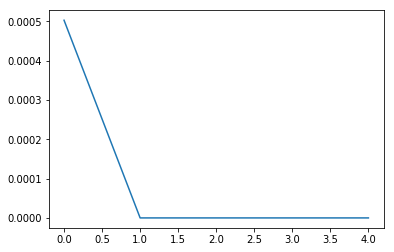

In [129]:
plt.plot(overall_cost)

In [142]:
X_ = tf.placeholder(shape=[None, 100, 100, 3], dtype=tf.float32)
y_ = tf.placeholder(shape=[None, 5], dtype=tf.float32)
    
Z = forward_pass(X_, parameters)
correct_pred = tf.equal(tf.argmax(Z, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, "float"))

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

#test_accuracy = sess.run(accuracy, {X_: test_data_norm, y_: test_labels_one_hot})
argZ = sess.run(tf.argmax(Z, 1), {X_: test_data_norm, y_: test_labels_one_hot})
argA = sess.run(tf.argmax(tf.nn.softmax(Z), 1), {X_: test_data_norm, y_: test_labels_one_hot})
argY = sess.run(tf.argmax(y_, 1), {X_: test_data_norm, y_: test_labels_one_hot})



In [ ]:
# Saving the model 